In [1]:
# IPython magic
from IPython.display import Image, HTML

# Occupancy detection - A multivariate time series example

In this tutorial, you will discover how to apply getML to multivariate time series. Therefore you will learn how to

1. [Interpret a time series as a relational data model](#make-the-data-model-relational)

2. [Correctly set up the data model](#defining-the-data-model)

3. [Study the resulting features using the getML monitor](#studying-the-features)

Our use case is a public domain data set for binary classification (room occupancy) from Temperature, Humidity, Light and CO2. The results achieved using getML excel all published results on this data set. Note that this is not only a neat use case for machine learning algorithms but a real-world application with tangible consequences: If room occupancy is known with sufficient certainty it can be applied to the control systems of a building. The saving in energy and money can be [up to 50 %](https://ieeexplore.ieee.org/document/7566062). If you want to follow along the code sections of this tutorial, make sure to [download](https://getml.com/product) and [install](https://docs.getml.com/latest/home/installation/installation.html) getML. 


**Introduction**

Usually, getML is considered as a tool for feature engineering an machine learning on relational data sets. Why can we apply it to (multivariate) time series?

The key is a _self-join_. Instead of creating feature my merging and aggregating peripheral tables in a relational data model, for a time-series, we perform the same operations on the population table itself. This results in features like these

* Aggregations over time, such as the average value of some column for the last 3 days.

* Seasonal effects, such as today is a Wednesday, so let's get the average value for the last four Wednesdays.

* Lag variables, such as get the value of some column from two hours ago.

Using getML's algorithms for relational learning, we can extract all of these features automatically. Having created a flat table of such features, we can then apply state-of-the-art machine learning algorithms, like xgboost. As you will see in this example, this performs even better than traditional time series analysis.

The present analysis is based on a public domain time series dataset. It is available in the [UC Irvine Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+). The challenge is straightforward: We want to predict whether an office room is occupied at a given moment in time using sensor data. The data is measured about once a minute. Ground-truth occupancy was obtained from time-stamped pictures. The available columns are

* Date, year-month-day hour:minute:second
* Temperature, in Celsius
* Relative Humidity, %
* Light, in Lux
* CO2, in ppm
* Humidity Ratio, Derived quantity from temperature and relative humidity, in kgwater-vapor/kg-air
* Occupancy, 0 or 1, 0 for not occupied, 1 for occupied status

As a reference and benchmark, we use [this paper](https://www.researchgate.net/profile/Luis_Candanedo_Ibarra/publication/285627413_Accurate_occupancy_detection_of_an_office_room_from_light_temperature_humidity_and_CO2_measurements_using_statistical_learning_models/links/5b1d843ea6fdcca67b690c28/Accurate-occupancy-detection-of-an-office-room-from-light-temperature-humidity-and-CO2-measurements-using-statistical-learning-models.pdf):

* Accurate occupancy detection of an office room from light, temperature, humidity and CO2 measurements using statistical learning models. Luis M. Candanedo, Veronique Feldheim. Energy and Buildings. Volume 112, 15 January 2016, Pages 28-39.

The authors apply various Artificial Neural Network algorithms to the data set at hand and achieved accuracies between 80.324% (Batch  Back algorithm) and 99.061% (Limited Memory Quasi-Newton algorithm).

## Data preparation

In [2]:
import os
from urllib import request
import numpy as np
import pandas as pd

import getml
print("getML version: {}".format(getml.__version__))

getML version: 0.10.0


First, we set the project

In [3]:
getml.engine.set_project('occupancy_detection')

Creating new project 'occupancy_detection'


The data set can be downloaded directly from GitHub. It is conveniently separated into a training, a validation and a testing set. This allows us to directly benchmark our results against the results of the original paper later.

In [4]:
fnames = [
    'datatraining.txt',
    'datatest.txt',
    'datatest2.txt'
]

for fname in fnames:
    if not os.path.exists(fname):
        fname, res = request.urlretrieve(
            "https://raw.githubusercontent.com/LuisM78/Occupancy-detection-data/master/" + fname, 
            fname
        )


The data file contain the row number Because the data files are not valid CSV, we first load them into pandas before uploading them to the getML engine.

In [5]:
datatraining_pandas = pd.read_csv('datatraining.txt')
datatest_pandas = pd.read_csv('datatest.txt')
datatest2_pandas = pd.read_csv('datatest2.txt')

data_train = getml.data.DataFrame.from_pandas(datatraining_pandas, name='data_train')
data_validate = getml.data.DataFrame.from_pandas(datatest_pandas, name='data_validate')
data_test = getml.data.DataFrame.from_pandas(datatest2_pandas, name='data_test')

The training data set looks like this

In [6]:
display(HTML(data_train.to_pandas().to_html(max_rows=10, border=0)))

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,date
0,23.18,27.2720,426.0,721.250000,0.004793,1.0,2015-02-04 17:51:00
1,23.15,27.2675,429.5,714.000000,0.004783,1.0,2015-02-04 17:51:59
2,23.15,27.2450,426.0,713.500000,0.004779,1.0,2015-02-04 17:53:00
3,23.15,27.2000,426.0,708.250000,0.004772,1.0,2015-02-04 17:54:00
4,23.10,27.2000,426.0,704.500000,0.004757,1.0,2015-02-04 17:55:00
...,...,...,...,...,...,...,...
8138,21.05,36.0975,433.0,787.250000,0.005579,1.0,2015-02-10 09:29:00
8139,21.05,35.9950,433.0,789.500000,0.005563,1.0,2015-02-10 09:29:59
8140,21.10,36.0950,433.0,798.500000,0.005596,1.0,2015-02-10 09:30:59
8141,21.10,36.2600,433.0,820.333333,0.005621,1.0,2015-02-10 09:32:00


We also assign roles to each column. To learn more about what roles do and why we need them, check out the [official documentation](https://docs.getml.com/latest/user_guide/annotating_data/annotating_data.html).

In [7]:
for df in [data_train, data_validate, data_test]:
    df.set_role(['Occupancy'], getml.data.roles.target)
    df.set_role(['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio'], getml.data.roles.numerical)
    df.set_role(['date'], getml.data.roles.time_stamp)

## Make the data model relational

In order to let getML interpret the time series as relational data model, we follow a simple, well-defined procedure

* Add a **dummy join key**. This is related to the self join mentioned above. If we add the same join key to every row in the data set we allow the feature engineering algorithm to establish relations between each row to all other rows in the data set. In this example, we can add a constant value to the entire data frame because we are dealing with only one big time series - most other time series data set contain more than just one time series.

* Add an **upper time stamp**. Upper time stamps impose an upper limit on the validity range of a certain row. In other words, by adding an upper time stamp we can add an "expiration date" for each row. This tells the feature engineering algorithm up to which point in the future is may consider this row for aggregations. Upper time stamps are a bit tricky to understand at first, but once you have wrapped your head around them, they are very powerful.

In SQL, a simplified version of what we are going for looks like this:

```sql
CREATE TABLE FEATURE_1 AS
SELECT SOME_AGGREGATION( t2.some_column ) AS feature_1,
       t1.join_key,
       t1.date
FROM data_train t1
LEFT JOIN data_train t2
ON t1.join_key = t2.join_key
WHERE (...some conditions...) 
AND t2.date <= t1.date
AND t2.upper_time_stamp > t1.date 
GROUP BY t1.join_key,
         t1.date;
```

This means, the feature engineering algorithm can only aggregate values from the past (```t2.date <= t1.date```), and only up to the upper time stamp (```t2.upper_time_stamp > t1.date```).

Before continuing to the actual analysis, we define a small helper function to convert minutes to days. This is because in getML numerical time stamps are always [interpreted as days](https://docs.getml.com/latest/user_guide/annotating_data/annotating_data.html#time-stamp) whereas in this data set everything is measured in the order of minutes

In [8]:
def minutes(x):
    """Helper function to convert minutes to days."""
    return x / 60.0 / 24.0

In the present example we choose to consider data within the last 10 minutes for creating our features.

In [9]:
for df in [data_train, data_validate, data_test]:
    # Add dummy join key
    df.add(np.ones(len(df)), 'join_key', getml.data.roles.join_key)
    # Add upper times stamp
    df.add(df["date"] + minutes(10),  "upper_time_stamp", getml.data.roles.time_stamp)

## Defining the data model

Now, we need to communicate the self-join and the upper time stamps to the feature engineering algorithms. This happens when creating the data model. We join the placeholder of the population table onto it self and impose the condition regarding the upper time stamp that was discussed above.

In [10]:
# Population placeholder
population = data_train.to_placeholder()

# Peripheral placeholder (equals population placeholder)
peripheral = data_train.to_placeholder()

# Perform join with time constraints
population.join(
    peripheral, 
    join_key="join_key", 
    time_stamp="date",
    upper_time_stamp="upper_time_stamp"
)

### Run the analysis

We use a [MultirelModel](https://docs.getml.com/latest/api/getml.models.MultirelModel.html) for generating the features and an [XGBoostClassifier](https://docs.getml.com/latest/api/getml.predictors.XGBoostClassifier.html#getml.predictors.XGBoostClassifier) for feature selection and prediction.

We do not spend much effort on the hyperparameters and largely go with the default values. The only exception is that we add some regularization to the XGBoostClassifiers.

In [11]:
feature_selector = getml.predictors.XGBoostClassifier(reg_lambda=500)

predictor = getml.predictors.XGBoostClassifier(reg_lambda=500)

model = getml.models.MultirelModel(
        num_features=30,
        population=population,
        peripheral=[peripheral],
        loss_function=getml.models.loss_functions.CrossEntropyLoss(),
        feature_selector=feature_selector,
        predictor=predictor,
        seed=1706
)

We now fit the model. This should take well under one minute, depending on your computer.

In [12]:
model = model.fit(
    population_table=data_train,
    peripheral_tables=[data_train]
)

Loaded data. Features are now being trained...
Trained model.
Time taken: 0h:0m:19.140246



Let's see how well we did by scoring the model.

In [13]:
in_sample = model.score(population_table=data_train,
              peripheral_tables=[data_train]
             )
out_of_sample = model.score(population_table=data_test,
              peripheral_tables=[data_test]
             )

print("Accuracy (training): {:.5f}\nAUC (training): {:.5f}\n\nAccuracy (testing): {:.5f}\nAUC (testing): {:.5f}".format(
    in_sample['accuracy'][0], in_sample['auc'][0], out_of_sample['accuracy'][0], out_of_sample['auc'][0]))

Accuracy (training): 0.99460
AUC (training): 0.99899

Accuracy (testing): 0.99210
AUC (testing): 0.99743


In the [original paper](https://www.researchgate.net/profile/Luis_Candanedo_Ibarra/publication/285627413_Accurate_occupancy_detection_of_an_office_room_from_light_temperature_humidity_and_CO2_measurements_using_statistical_learning_models/links/5b1d843ea6fdcca67b690c28/Accurate-occupancy-detection-of-an-office-room-from-light-temperature-humidity-and-CO2-measurements-using-statistical-learning-models.pdf), the authors tried several approaches. The best out-of-sample values of all the approaches they tried are the following:

* Accuracy (testing): 0.99061
* AUC (testing): 0.99574

Note that our results outperform the best approach from the original paper, both in terms of accuracy as well as AUC. 
This demonstrates how powerful getML's relational learning approach is also a powerful tool for time series.

## Studying the features

It is always a good idea to study the features the relational learning algorithm has extracted. We can do so in the [feature view](https://docs.getml.com/latest/user_guide/getml_suite/monitor/models.html#feature-view) of the getML monitor. Open the monitor and select the models tab in the sidebar. You will see an overview over the trained models. If you followed this tutorial, there should be only one model. Select it to see the most essential summary plots. Besides the accuracy and ROC curve of the model there are two plots related to the trained features.

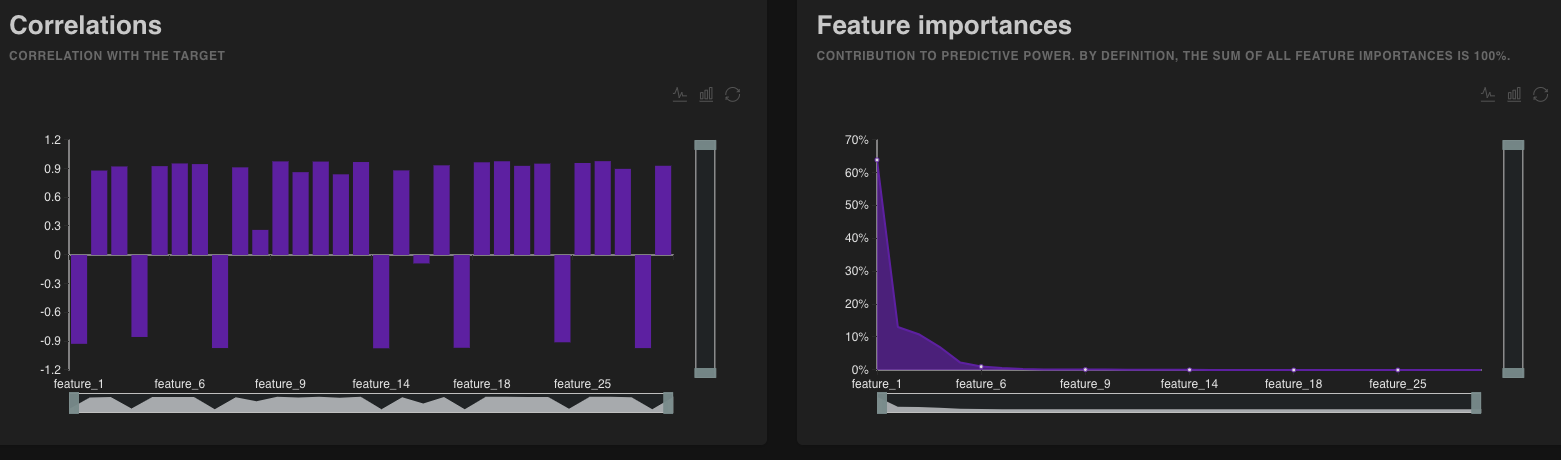

In [14]:
Image(filename="feature-1.png")

For each of the trained features they show the correlation with the target and the feature importance. The feature importance is calculated by XGBoost based on the improvement of the optimizing criterium at each split in the decision tree and is normalized to 100%. We first look at the most important feature. This feature is negatively correlated with the target (a correlation coefficient of -92%) and accounts for almost 64% of the total predictive power. By clicking on the feature_1 in the table below, the plots you can access more information on this feature. Most notably, its definition in SQL

```sql
CREATE TABLE FEATURE_1 AS
SELECT MIN( t1.date - t2.date ) AS feature_1,
       t1.join_key,
       t1.date
FROM (
     SELECT *,
            ROW_NUMBER() OVER ( ORDER BY join_key, date ASC ) AS rownum
     FROM data_train
) t1
LEFT JOIN data_train t2
ON t1.join_key = t2.join_key
WHERE (
   ( t2.Light > 458.172840 AND t1.Light > 502.583333 AND t2.Humidity > 26.403623 AND t2.Light <= 684.267857 )
OR ( t2.Light > 458.172840 AND t1.Light <= 502.583333 AND t2.Temperature > 22.264286 AND t2.Temperature > 22.315385 )
OR ( t2.Light > 458.172840 AND t1.Light <= 502.583333 AND t2.Temperature <= 22.264286 )
OR ( t2.Light <= 458.172840 AND t1.date - t2.date > 0.006185 )
OR ( t2.Light <= 458.172840 AND t1.date - t2.date <= 0.006185 AND t1.Light > 365.987395 )
OR ( t2.Light <= 458.172840 AND t1.date - t2.date <= 0.006185 AND t1.Light <= 365.987395 AND t1.Humidity > 37.597339 )
) AND t2.date <= t1.date
AND ( t2.upper_time_stamp > t1.date OR t2.upper_time_stamp IS NULL )
GROUP BY t1.rownum,
         t1.join_key,
         t1.date;
```

Simply speaking, this feature checks how long ago the light was last switched on. If that is relatively recent, it is more likely that the room is occupied. There are other factors, such as temperature and humidity that come into the equation as well.

Let's go back to the feature overview and check out the second most important feature: It has a strong positive correlation with the target (92%) and accounts for 17% of the predictive power. Its SQL definition reads

```sql
CREATE TABLE FEATURE_2 AS
SELECT MAX( t2.Temperature ) AS feature_2,
       t1.join_key,
       t1.date
FROM (
     SELECT *,
            ROW_NUMBER() OVER ( ORDER BY join_key, date ASC ) AS rownum
     FROM data_train
) t1
LEFT JOIN data_train t2
ON t1.join_key = t2.join_key
WHERE (
   ( t1.Light > 365.007463 AND t1.Temperature > 22.625156 AND t1.Temperature > 22.659000 AND t1.Light <= 522.805556 )
OR ( t1.Light > 365.007463 AND t1.Temperature > 22.625156 AND t1.Temperature <= 22.659000 AND t2.Temperature <= 22.622222 )
OR ( t1.Light > 365.007463 AND t1.Temperature <= 22.625156 AND t1.Humidity > 18.924881 AND t1.date - t2.date <= 0.000661 )
) AND t2.date <= t1.date
AND ( t2.upper_time_stamp > t1.date OR t2.upper_time_stamp IS NULL )
GROUP BY t1.rownum,
         t1.join_key,
         t1.date;

```

This feature is based on the maximum temperature in the relevant time window, given some other conditions. The higher the temperature, the more likely it is that the room is occupied.

These two feature demonstrate the power of getML feature engineering algorithms. It is very unlikely to find these features using manual, trial-and-error based methods. The general structure of features found using such methods might be similar, but you would have had to put in much more effort while getting worse results.

When browsing through the remaining features, you will notice that some are columns directly taken from the original table, such as *Light* and *CO2*. But these columns are less correlated and less important than the features generated with the relational model based on self-join and upper time stamps.

## Conclusion

This tutorial demonstrates that relational learning is a powerful tool for time series. We able to outperform the benchmarks for a scientific paper on a simple public domain time series data set using relatively little effort.

If you want to learn more about getML, check out the [official documentation](https://getml.com/product).

To reproduce the results in this notebook, you can [download getML for free](https://docs.getml.com/latest/). The code this tutorial is based on is available on [GitHub](https://github.com/getml/getml-examples/blob/master/python/projects/occupancy_detection/occupancy_detection.ipynb).
